# Basic Models: SVM and Naive Bayes

In [34]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import nltk
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("../data/data_small.csv", index_col=0)

In [3]:
df.head()

,dataset,text,logical_fallacies,source
18384,8,Testing on animals could save the life of you ...,appeal_to_emotion,NaN
11271,3,"I remember when China took over Hong Kong, I r...",none,NaN
15702,4,": The only ""Light at the End of the Tunnel"", i...",appeal_to_emotion,NaN
7148,3,So you only believe there are two ways to run ...,none,NaN
8147,3,Keep things the way they are or change them co...,false_dilemma,NaN


### Preprocess text

In [4]:
def preprocess_text(text):
    # Change text to lower cases
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'\W', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
df['text'] = df['text'].apply(preprocess_text)
df.head()

,dataset,text,logical_fallacies,source
18384,8,testing on animals could save the life of you ...,appeal_to_emotion,NaN
11271,3,i remember when china took over hong kong i re...,none,NaN
15702,4,the only light at the end of the tunnel is the...,appeal_to_emotion,NaN
7148,3,so you only believe there are two ways to run ...,none,NaN
8147,3,keep things the way they are or change them co...,false_dilemma,NaN


In [6]:
# Lemmatize text
lemmatize = nltk.WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatize.lemmatize(word) for word in text.split()])

df['text'] = df['text'].apply(lemmatize_text)
df.head()

,dataset,text,logical_fallacies,source
18384,8,testing on animal could save the life of you o...,appeal_to_emotion,NaN
11271,3,i remember when china took over hong kong i re...,none,NaN
15702,4,the only light at the end of the tunnel is the...,appeal_to_emotion,NaN
7148,3,so you only believe there are two way to run a...,none,NaN
8147,3,keep thing the way they are or change them com...,false_dilemma,NaN


In [7]:
Y = df["logical_fallacies"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=42)

### SVM

In [8]:
# Use TF-IDF Vecorizer to transform text into numerical data
tfidf_vecorizer = TfidfVectorizer()
X_vecorized = tfidf_vecorizer.fit_transform(X_train)
X_vecorized_test = tfidf_vecorizer.transform(X_test)

In [ ]:
# Open SVM model when it is already trained
with open('../models/svm_model.pkl', 'rb') as f:
        model = pickle.load(f)

In [46]:
# Runs model only if it was not loaded in the previous cell
if model == False:
    # Grid search
    param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
    }

    svm = SVC(probability=True)

    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_vecorized, y_train)

    best_params = grid_search.best_params_
    print(best_params)

    # Predict on train and test data
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_vecorized)
    y_test_pred = best_model.predict(X_vecorized_test)

    # Save model to pickle file:
    with open('../models/svm_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
        

else: # makes prediction for saved model
    y_train_pred = model.predict(X_vecorized)
    y_test_pred = model.predict(X_vecorized_test)


In [15]:
def __compute_and_log_metrics(
    y_true: pd.Series,
    y_pred: pd.Series,
    prefix: str = "train",
    average: str = "macro"  # 'macro' is suitable for most multiclass scenarios
):
    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    print(accuracy, recall, precision, f1)
    print(f"Multiclass classification performance on {prefix} set: "
        f"Accuracy = {accuracy:.1%}, "
        f"Recall = {recall:.1%}, "
        f"Precision = {precision:.1%}, "
        f"F1 = {f1:.1%}")
    
    print(type(accuracy))

In [22]:
__compute_and_log_metrics(y_train, y_train_pred, "train")
__compute_and_log_metrics(y_test, y_test_pred, "test")

0.884 0.8124704796635475 0.9379901923482796 0.8631632618330296
Multiclass classification performance on train set: Accuracy = 88.4%, Recall = 81.2%, Precision = 93.8%, F1 = 86.3%
<class 'numpy.float64'>
0.6373333333333333 0.4781058378808691 0.6963732193732194 0.5271944422498412
Multiclass classification performance on test set: Accuracy = 63.7%, Recall = 47.8%, Precision = 69.6%, F1 = 52.7%
<class 'numpy.float64'>


In [17]:
print(classification_report(y_test, y_test_pred))

                       precision    recall  f1-score   support

           ad_hominem       0.64      0.52      0.57       159
  appeal_to_authority       0.75      0.22      0.34        97
    appeal_to_emotion       0.59      0.52      0.55       227
        false_dilemma       0.80      0.42      0.55       133
faulty_generalization       0.78      0.28      0.41       202
                 none       0.62      0.91      0.74       682

             accuracy                           0.64      1500
            macro avg       0.70      0.48      0.53      1500
         weighted avg       0.66      0.64      0.61      1500



In [31]:
# Get base_probs
base_probs = best_model.predict_proba(X_vecorized_test)
base_probs


array([[0.00898322, 0.00323032, 0.01207795, 0.01590949, 0.00600508,
        0.95379394],
       [0.0068144 , 0.02091489, 0.00352363, 0.04344598, 0.03072252,
        0.89457859],
       [0.02472325, 0.01702059, 0.06758043, 0.01678032, 0.10553292,
        0.76836248],
       ...,
       [0.0112163 , 0.10717307, 0.01765658, 0.0443113 , 0.07715577,
        0.74248698],
       [0.0231388 , 0.06512713, 0.0789737 , 0.01291245, 0.04802383,
        0.77182408],
       [0.01524593, 0.08447687, 0.03947265, 0.62690558, 0.05314447,
        0.18075451]])

In [32]:
# Brier score
# 1. One-hot encode the true labels (y_test)
lb = LabelBinarizer()
y_true_onehot = lb.fit_transform(y_test)  # Shape: (n_samples, n_classes)
# 2. Compute Brier score for multiclass
brier_score = np.mean(np.sum((base_probs - y_true_onehot) ** 2, axis=1))
print("Multiclass Brier score:", brier_score)

Multiclass Brier score: 0.49862718285668095


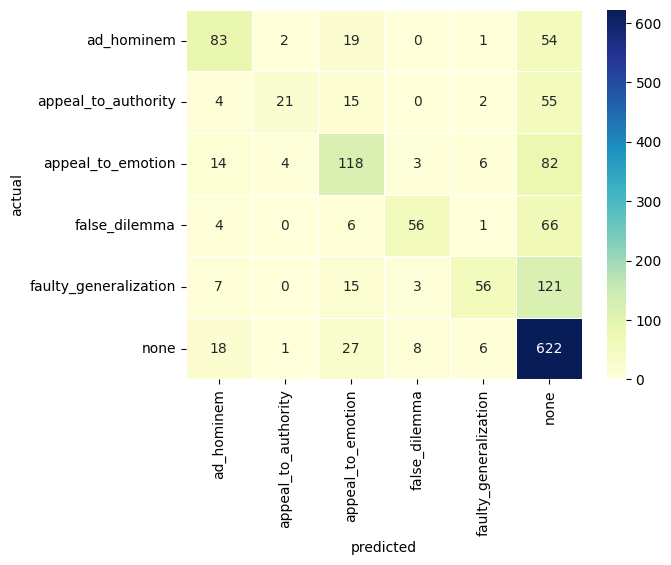

In [15]:

cm = confusion_matrix(y_test, y_test_pred)
labels = sorted(df['logical_fallacies'].unique())

sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5, xticklabels=labels, yticklabels=labels);
plt.xlabel("predicted")
plt.ylabel("actual")

plt.show()

In [71]:
labels_count = df['logical_fallacies'].value_counts()
print(labels_count)

logical_fallacies
none                     2346
appeal_to_emotion         754
faulty_generalization     635
ad_hominem                498
false_dilemma             439
appeal_to_authority       328
Name: count, dtype: int64


### Naive Bayes

In [17]:
# Pipeline for TF-IFD and Naive Bayes
pipeline_bayes = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Train the model
pipeline_bayes.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_bayes = pipeline_bayes.predict(X_train)
y_test_pred_bayes = pipeline_bayes.predict(X_test)

__compute_and_log_metrics(y_train, y_train_pred_bayes, "train")
__compute_and_log_metrics(y_test, y_test_pred_bayes, "test")

0.49142857142857144 0.18717955574795095 0.7353085753056675 0.14785729294128555
Multiclass classification performance on train set: Accuracy = 49.1%, Recall = 18.7%, Precision = 73.5%, F1 = 14.8%
<class 'float'>
0.458 0.17123244549003847 0.5205168305034257 0.11386365348327637
Multiclass classification performance on test set: Accuracy = 45.8%, Recall = 17.1%, Precision = 52.1%, F1 = 11.4%
<class 'float'>


/Users/aylinhanne/Documents/neuefische/capstone_project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aylinhanne/Documents/neuefische/capstone_project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
